# Mask R-CNN (Image Segmentation) Inference
We'll start by importing the required packages and defining some essential paths (change the paths to wherever those files are on your system).

In [1]:
# external packages
import skimage.io
import matplotlib.pyplot as plt
import numpy as np

# mask r-cnn components
from mrcnn.config import Config
import mrcnn.model as modellib
from mrcnn import utils
from mrcnn import visualize

# paths
DATASET_PATH = '../data/wad'
LOGS_PATH = './logs'

MRCNN_MODEL_WEIGHTS = './image_seg/mask_rcnn_wad.h5'

Using TensorFlow backend.


## Configuration & Dataset

In [2]:
from train.wad_dataset import WadConfig, WadDataset


# WAD Configuration
class WADInferenceConfig(WadConfig):
    BATCH_SIZE = 1                  # in testing mode, we want to run on only 1 image at a time
    IMAGES_PER_GPU = 1              # we only need 1 image (and 1 gpu)
    DETECTION_MIN_CONFIDENCE = 0    # we take all detections, regardless of confidence


wad_config = WADInferenceConfig()

# Dataset: the entire 'train' dataset for CVPR WAD 2018
dataset = WadDataset()
dataset.load_data(DATASET_PATH, 'train', labeled=False, use_pickle=False)
dataset.prepare()

print('Number of Images in Dataset: {}'.format(dataset.num_images))

Number of Images in Dataset: 39222


## Load Model

In [8]:
# Create model in inference mode
model = modellib.MaskRCNN(mode="inference", config=wad_config, model_dir=LOGS_PATH)

# Load our pre-trained weights
model.load_weights(MRCNN_MODEL_WEIGHTS, by_name=True)

## Inference

First, let's visually inspect our output to make sure it looks sensible.

Running detection on image 22984 (filename: 170927_070438942_Camera_6.jpg)
Processing 1 images
image                    shape: (2710, 3384, 3)       min:    0.00000  max:  255.00000  uint8
molded_images            shape: (1, 1024, 1024, 3)    min: -123.70000  max:  151.10000  float64
image_metas              shape: (1, 48)               min:    0.00000  max: 3384.00000  float64
anchors                  shape: (1, 261888, 4)        min:   -0.35390  max:    1.29134  float32


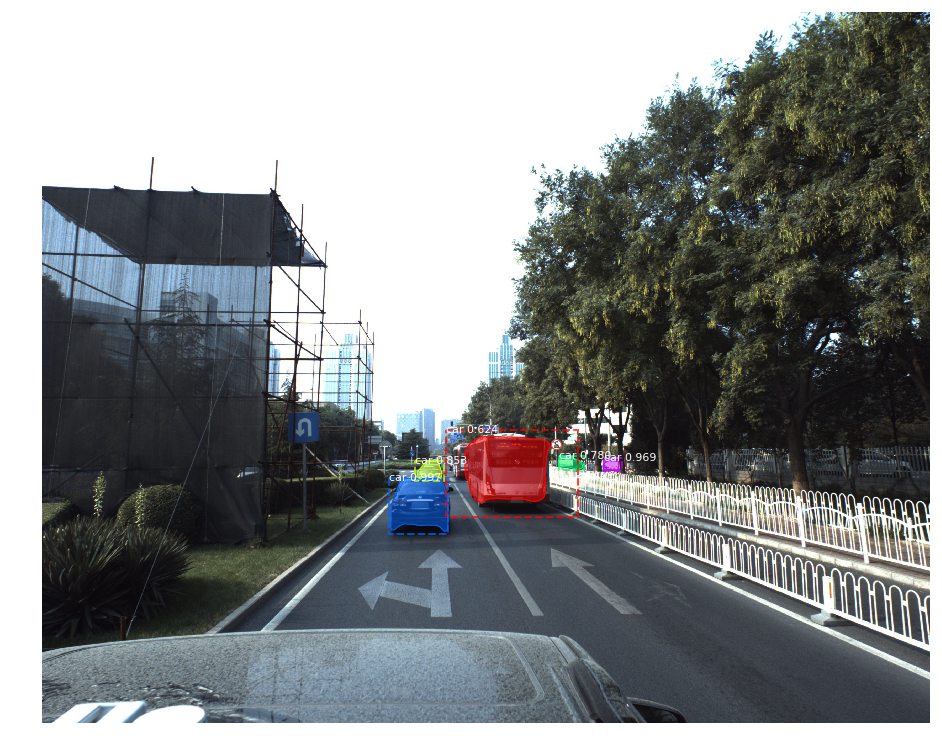

In [9]:
from train.wad_dataset import index_to_class_names

# Load a random image from the dataset
image_id = np.random.randint(0, dataset.num_images)
image = dataset.load_image(image_id)

print(f'Running detection on image {image_id} (filename: {dataset.image_info[image_id]["path"]})')

# Run inference on our model
results = model.detect([image], verbose=1)[0]

# Visualize and plot the detections we get from mrcnn
visualize.display_instances(image, results['rois'], results['masks'], results['class_ids'], 
                            index_to_class_names, results['scores'])

## Statistics

Now, we'll numerically check the performance of our model by looking at the average precision (AP) for each image and the overall mean average precision (mAP).

In [ ]:
# Calculate Average Precision (AP) for each image
APs = []
for image_id in range(dataset.num_images):
    # Load image and ground truth data
    image, image_meta, gt_class_id, gt_bbox, gt_mask =\
        modellib.load_image_gt(dataset, wad_config,
                               image_id, use_mini_mask=False)
    molded_images = np.expand_dims(modellib.mold_image(image, wad_config), 0)
    
    # Run object detection
    results = model.detect([image], verbose=0)
    r = results[0]
    
    # Compute AP
    AP, _, _, _ = utils.compute_ap(gt_bbox, gt_class_id, gt_mask,
                                   r["rois"], r["class_ids"], r["scores"], r['masks'])
    APs.append(AP)
    
    print('Image: {0:3d}\tAP: {1:1.4f}'.format(image_id, AP))
    
# Calculate mAP score for dataset
print("mAP: ", np.mean(APs))